In [106]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")

# Corrective RAG Implementation
## https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/

## https://arxiv.org/pdf/2401.15884

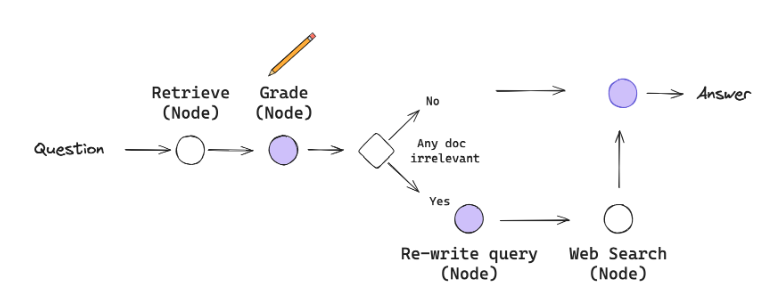

In [107]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode
from typing import Literal

In [108]:
# LLM
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o", temperature=0)

# Embedding
from langchain_openai import OpenAIEmbeddings
embeddings=OpenAIEmbeddings(model="text-embedding-3-large")

In [109]:
# Data ingention loading 
# List of URLs to load
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
# loading data using webloader
from langchain_community.document_loaders import WebBaseLoader

# Create a loader
loader = WebBaseLoader(urls)

# Load the documents
documents = loader.load()

doc_list = []

In [110]:
# spliting 
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(documents)

In [111]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [112]:
from langchain_community.vectorstores import Chroma
# Store document to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
vec_retriever = vectorstore.as_retriever()

In [113]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [114]:

#retriever
def retriever(state:GraphState):
    """
    Retrieve documents

    Args:
        state (dict) : The current graph state

    Returns:
        state (dict) : New key added to state - documents : which contrains retrieved documents
    """
    print("------RETRIEVER---------")
    question = state["question"]
    documents = vec_retriever.invoke(question)
    return {"documents":documents , "question" : question}

In [115]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

def reWritter(state:GraphState):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("------RE-WRITTER---------")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


In [116]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
web_search_tool = TavilySearchResults(k=3)

def webSearch(state:GraphState):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("------WEB-SEARCH---------")
    question = state["question"]
    documents = state["documents"]

    print(f"------QUESTION FOR WEBSEARCH---------{question}")
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

In [117]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
# Prompt
prompt = hub.pull("rlm/rag-prompt")
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def output_generator(state:GraphState):
    """
    Generate Output

    Args:
        state (dict): The current graph state

    Return: 
        state (dict): New key addes to state, generation - that contains LLM generated output  
    """
    print("------OUTPUT GENERATOR---------")
    documents=state["documents"]
    question=state["question"]
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    
    generation = rag_chain.invoke({"context":documents,"question":question})
    return {"documents":documents , "question" : question , "generation" : generation} 


In [118]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_grader

def grader(state:GraphState):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
 


In [119]:
def grade_decider(state:GraphState):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "query_rewritter"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate_output"

In [120]:
crag_flow = StateGraph(GraphState)

#nodes
crag_flow.add_node("Retriever",retriever)
crag_flow.add_node("Grader",grader)
crag_flow.add_node("Output Generator",output_generator)
crag_flow.add_node("Re-Writter",reWritter)
crag_flow.add_node("Web Search",webSearch)

#edges
crag_flow.add_edge(START,"Retriever")
crag_flow.add_edge("Retriever","Grader")
crag_flow.add_conditional_edges("Grader",
                                grade_decider,
                                {
                                    "generate_output":"Output Generator",
                                    "query_rewritter":"Re-Writter"
                                })

crag_flow.add_edge("Re-Writter","Web Search")

crag_flow.add_edge("Web Search","Output Generator")

crag_flow.add_edge("Output Generator",END)




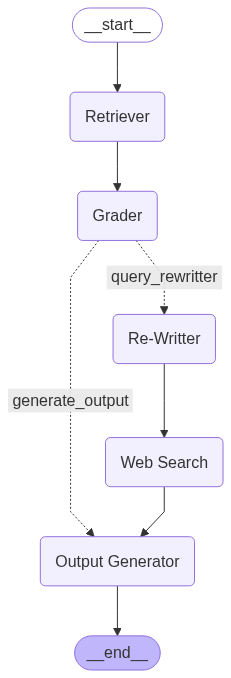

In [121]:
crag_app=crag_flow.compile()

from IPython.display import Image, display
display(Image(crag_app.get_graph(xray=True).draw_mermaid_png()))

In [122]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in crag_app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

------RETRIEVER---------
"Node 'Retriever':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'Grader':"
'\n---\n'
------RE-WRITTER---------
"Node 'Re-Writter':"
'\n---\n'
------WEB-SEARCH---------
------QUESTION FOR WEBSEARCH---------What are the different types of memory used by artificial intelligence agents?
"Node 'Web Search':"
'\n---\n'
------OUTPUT GENERATOR---------
"Node 'Output Generator':"
'\n---\n'
('Artificial intelligence agents use several types of memory: short-term '
 'memory, long-term memory, dynamic memory, episodic memory, and semantic '
 'memory. Short-term memory holds immediate context, while long-term memory '
 'persists knowledge across sessions. Dynamic memory allows access to '
 'real-time data, episodic me

In [126]:
from pprint import pprint

# Run
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in crag_app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

------RETRIEVER---------
"Node 'Retriever':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'Grader':"
'\n---\n'
------RE-WRITTER---------
"Node 'Re-Writter':"
'\n---\n'
------WEB-SEARCH---------
------QUESTION FOR WEBSEARCH---------What are the key concepts and findings of the AlphaCodium research paper?
"Node 'Web Search':"
'\n---\n'
------OUTPUT GENERATOR---------
"Node 'Output Generator':"
'\n---\n'
('The AlphaCodium research paper introduces a code-oriented flow that '
 'iteratively runs and fixes generated code against input-output tests, '
 'significantly improving the performance of language models on code '
 'generation tasks. Key elements include generating additional data for '
 'problem reflection and test reasoning, and